In [4]:
# Installing split-folders package
!pip install split-folders

In [5]:
# Suppresses warnings for cleaner output
import warnings
warnings.filterwarnings(action="ignore")  

# Import libraries
import matplotlib.pyplot as plt  # For plotting metrics
import numpy as np  # For numerical operations
import seaborn as sns

# Keras / TensorFlow imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # For image data augmentation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, LearningRateScheduler  # For early stopping the model training

# Sklearn imports for metrics
from sklearn.metrics import confusion_matrix, classification_report  # For performance evaluation
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve, average_precision_score


In [6]:
# Splitting the dataset
import splitfolders
splitfolders.ratio(
    "C:\\ctdataset\\CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone",
    output="C:\\dataset",
    seed=1337,
    ratio=(.8, .1, .1)
)

In [7]:
# Function to count images per class in a directory
import os

def count_images_per_class(directory):
    class_counts = {}
    for class_name in os.listdir(directory):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            class_counts[class_name] = len(os.listdir(class_dir))
    return class_counts

In [8]:
# Defining Data Directories (updated after split)
train_dir = 'C:/dataset/train'
val_dir = 'C:/dataset/val'
test_dir = 'C:/dataset/test'

In [9]:
# Get counts
train_counts = count_images_per_class(train_dir)
val_counts = count_images_per_class(val_dir)
test_counts = count_images_per_class(test_dir)

# Print the results
print("Training set distribution:", train_counts)
print("Validation set distribution:", val_counts)
print("Test set distribution:", test_counts)

Training set distribution: {'Cyst': 2967, 'Normal': 4061, 'Stone': 1101, 'Tumor': 1826}
Validation set distribution: {'Cyst': 370, 'Normal': 507, 'Stone': 137, 'Tumor': 228}
Test set distribution: {'Cyst': 372, 'Normal': 509, 'Stone': 139, 'Tumor': 229}


In [10]:
# Defining Image Parameters
IMG_SIZE = (150, 150)  # Consistent image size
BATCH_SIZE = 32
COLOR_MODE = 'grayscale'  # Consistent color mode across train, val, test

In [11]:
# Data Augmentation for training set
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation and Test Data Generators (no augmentation)
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
def simple_generator():
    while True:
        images, labels = next(train_generator)
        weights = [class_weight[label.argmax()] for label in labels]  
        weights = np.array(weights)  
        yield images, labels, weights

In [13]:
# Loading the datasets using ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    color_mode=COLOR_MODE,
    class_mode='categorical',
    shuffle=False
)

Found 9955 images belonging to 4 classes.
Found 1242 images belonging to 4 classes.
Found 1249 images belonging to 4 classes.


In [14]:
unique_classes, counts = np.unique(train_generator.classes, return_counts=True)
print("Class Distribution in Training Data:")
for cls, count in zip(unique_classes, counts):
    print(f"Class {cls}: {count} images")

Class Distribution in Training Data:
Class 0: 2967 images
Class 1: 4061 images
Class 2: 1101 images
Class 3: 1826 images


In [15]:
# Model Architecture
model = Sequential([
    # First Convolutional Block
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Second Convolutional Block
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Third Convolutional Block
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Fourth Convolutional Block
    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    # Flatten the feature maps
    Flatten(),

    # Dense Layers
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    # Output Layer (4 classes: Normal, Cyst, Tumor, Stone)
    Dense(4, activation='softmax')  # 4 classes for the 4 categories
])

In [16]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

In [17]:
# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 148, 148, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 72, 72, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 34, 34, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 15, 15, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,004,804 (7.65 MB)

 Trainable params: 2,003,460 (7.64 MB)

 Non-trainable params: 1,344 (5.25 KB)

In [ ]:
for layer in model.layers:
    print(f"Layer: {layer.name}, Input Shape: {layer.input_shape}, Output Shape: {layer.output_shape}")


In [18]:
print("Class Indices Mapping:", train_generator.class_indices)

Class Indices Mapping: {'Cyst': 0, 'Normal': 1, 'Stone': 2, 'Tumor': 3}


In [19]:
# Compute class weights
class_weight_list = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes
)

# Convert to dictionary
class_weight = dict(enumerate(class_weight_list))

# Convert values to Python float
class_weight = {k: float(v) for k, v in class_weight.items()}

print("Computed Class Weights:", class_weight)

Computed Class Weights: {0: 0.8388102460397708, 1: 0.612841664614627, 2: 2.260445049954587, 3: 1.3629518072289157}


In [20]:
# Callbacks
tensorboard = TensorBoard(log_dir='./logs')
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('kidney_disease_model.keras', save_best_only=True, monitor='val_accuracy')
annealer = LearningRateScheduler(lambda epoch: 1e-3 * 0.98 ** epoch, verbose=1)

In [21]:
# Training the model
history = model.fit(
    simple_generator(),  # Use simple_generator instead of train_generator
    steps_per_epoch=len(train_generator),  # Ensure the number of steps per epoch is correct
    epochs=50,
    validation_data=val_generator,
    validation_steps=len(val_generator),  # Set validation steps
    callbacks=[early_stopping, model_checkpoint, tensorboard, annealer]
)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 452s 1s/step - accuracy: 0.4337 - loss: 1.6548 - precision: 0.4663 - recall: 0.3672 - val_accuracy: 0.2979 - val_loss: 18.1890 - val_precision: 0.2979 - val_recall: 0.2979 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.00098.
Epoch 2/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 269s 861ms/step - accuracy: 0.5624 - loss: 1.0885 - precision: 0.6012 - recall: 0.4697 - val_accuracy: 0.3108 - val_loss: 3.8134 - val_precision: 0.3117 - val_recall: 0.3100 - learning_rate: 9.8000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009603999999999999.
Epoch 3/50
312/312 ━━━━━━━━━━━━━━━━━━━━ 268s 858ms/step - accuracy: 0.6914 - loss: 0.7735 - precision: 0.7330 - recall: 0.6278 - val_accuracy: 0.5998 - val_loss: 1.0669 - val_precision: 0.6114 - val_recall: 0.5548 - learning_rate: 9.6040e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.000941192.


In [22]:
# Evaluate on the test set
test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Precision: {test_precision}')
print(f'Test Recall: {test_recall}')

40/40 ━━━━━━━━━━━━━━━━━━━━ 28s 695ms/step - accuracy: 0.9909 - loss: 0.0258 - precision: 0.9909 - recall: 0.9909
Test Accuracy: 0.989591658115387
Test Precision: 0.989591658115387
Test Recall: 0.989591658115387


In [23]:
# Predictions on the test set
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 337ms/step


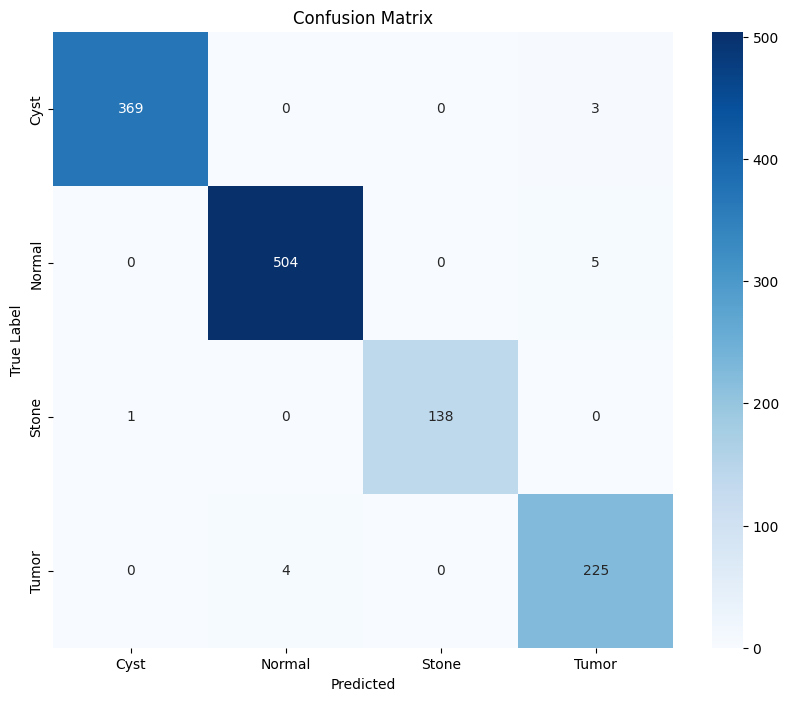

In [ ]:
# Confusion Matrix Heatmap
class_names = list(test_generator.class_indices.keys())
cm = confusion_matrix(test_generator.classes, y_pred) 

# Plotting the confusion matrix heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [40]:
# Classification Report
# Convert probabilities to class labels
y_pred_class = np.argmax(y_pred, axis=1)  # This will give you the class indices (0, 1, 2, or 3)

target_names = ['Normal', 'Cyst', 'Tumor', 'Stone']

# Generate the classification report
print("Classification Report:")
print(classification_report(y_true, y_pred_class, target_names=target_names))


Classification Report:
              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99       372
        Cyst       0.99      0.99      0.99       509
       Tumor       1.00      0.99      1.00       139
       Stone       0.97      0.98      0.97       229

    accuracy                           0.99      1249
   macro avg       0.99      0.99      0.99      1249
weighted avg       0.99      0.99      0.99      1249



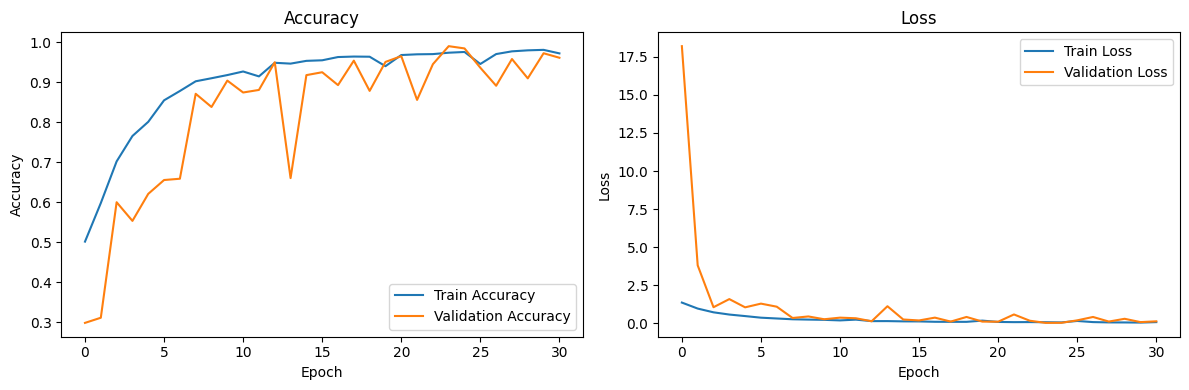

In [28]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

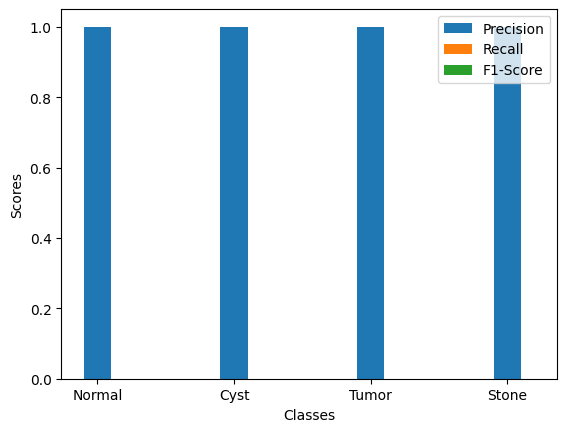

In [42]:
# Class-wise Performance Metrics (Bar Chart)

import matplotlib.pyplot as plt

# Plot bar chart for precision, recall, and F1-score
labels = ['Normal', 'Cyst', 'Tumor', 'Stone']
metrics = [precision_per_class, recall_per_class, f1_score_per_class]

x = range(n_classes)
plt.bar(x, metrics[0], width=0.2, label='Precision', align='center')
plt.bar(x, metrics[1], width=0.2, label='Recall', align='edge')
plt.bar(x, metrics[2], width=0.2, label='F1-Score', align='edge')

plt.xlabel('Classes')
plt.ylabel('Scores')
plt.xticks(x, labels)
plt.legend()
plt.show()




40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 216ms/step


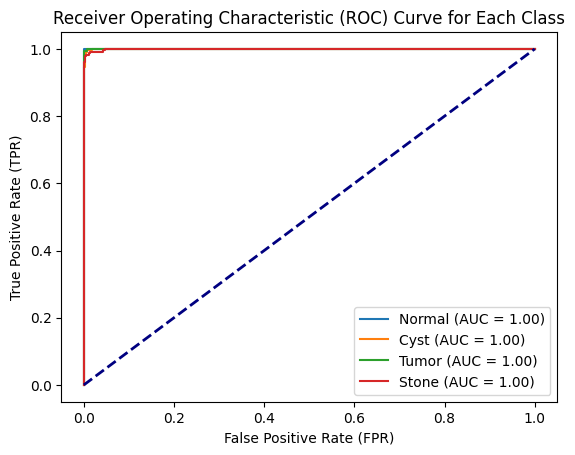

In [50]:
# ROC Curve (Receiver Operating Characteristic Curve)
y_true = label_binarize(test_generator.classes, classes=[0, 1, 2, 3])
y_pred = model.predict(test_generator)  # Model predictions (probabilities)

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])  # Compute ROC for class 'i'
    roc_auc = auc(fpr, tpr)  # Compute AUC for class 'i'

    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line (random classifier)
plt.title('Receiver Operating Characteristic (ROC) Curve for Each Class')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc='lower right')
plt.show()

In [52]:
# Save the model
model.save('kidney_disease_detection_model_saujanya.keras')